## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
from pathlib import Path

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
sys.path.append('/home/k64835/Master-Thesis-SITS')

scripts_path = Path("../Data-Preprocessing/").resolve()
sys.path.append(str(scripts_path))

scripts_path = Path("../Evaluation/").resolve()
sys.path.append(str(scripts_path))

In [3]:
import pickle
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestCentroid
from scripts.data_visualiser import *
from sklearn.manifold import TSNE 
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from model_scripts.subpatch_extraction import *
from scripts.data_loader import *
from scripts.data_preprocessor import *
from scripts.temporal_data_preprocessor import *
from scripts.temporal_data_loader import *
from scripts.temporal_visualiser import *
from scripts.temporal_chanel_refinement import *
from model_scripts.model_helper import *
from model_scripts.dataset_creation import *
from model_scripts.train_model_ae import *
from model_scripts.model_visualiser import *
from model_scripts.clustering import *
from model_scripts.train_model_dcec import *
from evaluation_scripts.evaluation_helper import *
from evaluation_scripts.result_visualiser import *
from Pipeline.temporal_preprocessing_pipeline import *
from evaluation_scripts.result_visualiser import *
from Pipeline.temporal_preprocessing_pipeline import *
import numpy as np
import config as config
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import skimage.measure
import torch
import torch.nn as nn
import torch.optim as optim

## Dataset prep: B10

### Loading the pre-processed data

Data: Extracted and Pre-processed Patches (each patch containing a sugarbeet field)

Dimensions: (N, T, C, H, W) = (N, 7, 10, 64, 64)

In [4]:
preprocessing_pipeline = PreProcessingPipelineTemporal()
field_numbers_train, acquisition_dates_train, patch_tensor_train, images_visualisation_train = preprocessing_pipeline.get_processed_temporal_cubes('train', 'allbands')
field_numbers_eval, acquisition_dates_eval, patch_tensor_eval, images_visualisation_eval = preprocessing_pipeline.get_processed_temporal_cubes('eval', 'allbands')
patch_tensor_train.shape, patch_tensor_eval.shape

(torch.Size([2425, 7, 10, 64, 64]), torch.Size([48, 7, 10, 64, 64]))

### Create Sub-Patches

In [5]:
train_subpatches, train_subpatch_coords = non_overlapping_sliding_window(patch_tensor_train, field_numbers_train, patch_size=config.subpatch_size)
eval_subpatches, eval_subpatch_coords = non_overlapping_sliding_window(patch_tensor_eval, field_numbers_eval, patch_size=config.subpatch_size)
train_subpatches.shape, eval_subpatches.shape

(torch.Size([39042, 7, 10, 5, 5]), torch.Size([867, 7, 10, 5, 5]))

Get field numbers and co-ordinates as string

In [6]:
train_coord_dataloader = get_string_fielddata(train_subpatch_coords)
eval_coord_dataloader = get_string_fielddata(eval_subpatch_coords)
train_coord_dataloader[0]

'1167134.0_25_25'

### Split Unlabeled data into 'train' and 'test' and create  Data Loaders

In [7]:
train_subpatches_dl, test_subpatches, train_field_numbers, test_field_numbers = train_test_split(
    train_subpatches, train_coord_dataloader, test_size=1-config.ae_train_test_ratio, random_state=42
)

dataloader_train = create_data_loader(train_subpatches_dl, train_field_numbers, batch_size=config.ae_batch_size, shuffle=True)
dataloader_test = create_data_loader(test_subpatches, test_field_numbers, batch_size=config.ae_batch_size, shuffle=False)
dataloader_eval = create_data_loader(eval_subpatches, eval_coord_dataloader, batch_size=config.ae_batch_size, shuffle=False)

/home/k64835/Master-Thesis-SITS/Modeling/model_scripts/dataset_creation.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32).permute(0, 2, 1, 3, 4)   # (N, T, C, H, W) -> (N, C, T, H, W)


## Architecture 1: Conv3D Autoencoder with 1D Time Convolution

### Architecture

Input Data: ( N x C x D x H x W )

In [9]:
class Conv3DAutoencoder(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv3DAutoencoder, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels

        # --- Encoder (3D Convolutions) ---
        self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- 1D Convolution (Time Aggregation) ---
        self.conv1d = nn.Conv1d(256 * patch_size * patch_size, 256 * patch_size * patch_size, kernel_size=time_steps, stride=1, padding=0, groups=128 * patch_size * patch_size)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * patch_size * patch_size, 512)   
        self.fc2 = nn.Linear(512, latent_size)

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * patch_size * patch_size)  

        # --- 1D Deconvolution to Expand Time Back ---
        self.deconv1d = nn.ConvTranspose1d(256 * patch_size * patch_size, 256 * patch_size * patch_size, kernel_size=time_steps, stride=1, padding=0, groups=128 * patch_size * patch_size)

        # --- 3D Deconvolutions ---
        self.unflatten = nn.Unflatten(1, (256, patch_size, patch_size))
        self.deconv1 = nn.ConvTranspose3d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose3d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose3d(64, in_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        
        # --- Encoder ---
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Reshape for 1D Conv ---
        b, c, t, h, w = x.shape  
        # print("x shape initial: ",x.shape)
        x = x.view(b, c * h * w, t)                     # (batch, 800, time)

        # print(f"Shape before 1D Conv: {x.shape}") 
        x = self.conv1d(x)                              # Time aggregation
        # print(f"Shape after 1D Conv: {x.shape}")      # (batch, 800, 1)

        # --- Flatten and Fully Connected ---
        x = self.flatten(x)  
        x = F.relu(self.fc1(x))
        z = self.fc2(x) 

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x)) 

        # --- Expand Time Back ---
        x = x.view(b, 6400, 1)  
        x = self.deconv1d(x) 
        # print(f"Shape after Deconv1D: {x.shape}")  # (batch, 800, time_steps)

        # --- Reshape for 3D Deconvolutions ---
        x = x.view(b, -1, self.time_steps, h, w)  
        # print("x before unflatten", x.shape)

        # --- 3D Deconvolutions ---
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x_reconstructed = self.deconv3(x)  

        return z, x_reconstructed


### Training

In [10]:
device = 'cuda'
epochs = 50
lr = 0.01
momentum=0.9
latent_dim=32
channels = 10
time_steps = 7
optimizer = 'SGD'
patch_size = config.subpatch_size

model = Conv3DAutoencoder(channels, time_steps, latent_dim, config.subpatch_size)
device = torch.device(device)  
model.to(device)

Conv3DAutoencoder(
  (conv1): Conv3d(10, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv1d): Conv1d(6400, 6400, kernel_size=(7,), stride=(1,), groups=3200)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=6400, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=6400, bias=True)
  (deconv1d): ConvTranspose1d(6400, 6400, kernel_size=(7,), stride=(1,), groups=3200)
  (unflatten): Unflatten(dim=1, unflattened_size=(256, 5, 5))
  (deconv1): ConvTranspose3d(256, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deconv2): ConvTranspose3d(128, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (dec

In [11]:
trained_model, train_losses, test_losses  = train_model_ae(model, dataloader_train, dataloader_test, epochs=epochs, optimizer=optimizer, lr=lr, momentum=momentum, device=device)

Epoch 1/100, Train Loss: 0.002469, Test Loss: 0.001900
Epoch 2/100, Train Loss: 0.000667, Test Loss: 0.000896
Epoch 3/100, Train Loss: 0.000462, Test Loss: 0.001080
Epoch 4/100, Train Loss: 0.000336, Test Loss: 0.000328
Epoch 5/100, Train Loss: 0.000248, Test Loss: 0.000620
Epoch 6/100, Train Loss: 0.000239, Test Loss: 0.000387
Epoch 7/100, Train Loss: 0.000215, Test Loss: 0.000209
Epoch 8/100, Train Loss: 0.000211, Test Loss: 0.000315
Epoch 9/100, Train Loss: 0.000199, Test Loss: 0.000333
Epoch 10/100, Train Loss: 0.000191, Test Loss: 0.000351
Epoch 11/100, Train Loss: 0.000182, Test Loss: 0.000310
Epoch 12/100, Train Loss: 0.000169, Test Loss: 0.000171
Epoch 13/100, Train Loss: 0.000160, Test Loss: 0.000156
Epoch 14/100, Train Loss: 0.000151, Test Loss: 0.000185
Epoch 15/100, Train Loss: 0.000150, Test Loss: 0.000196
Epoch 16/100, Train Loss: 0.000146, Test Loss: 0.000159
Epoch 17/100, Train Loss: 0.000142, Test Loss: 0.000192
Epoch 18/100, Train Loss: 0.000137, Test Loss: 0.000295
E

### Evaluation

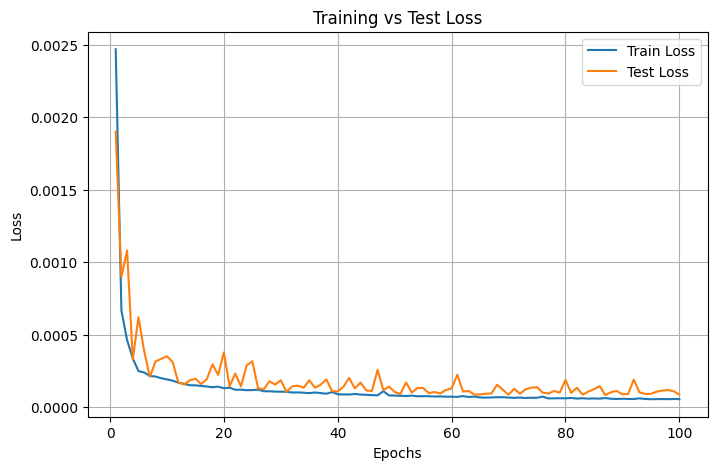

In [12]:
plot_loss(train_losses, test_losses)

Use trained Encoder part to get the features for train, test and evaluation Data

In [13]:
train_features, train_coord_dl = extract_features_ae(trained_model, dataloader_train, device)
test_features, test_coord_dl = extract_features_ae(trained_model, dataloader_test, device)
eval_features, eval_coord_dl = extract_features_ae(trained_model, dataloader_eval, device)

train_features = train_features.cpu()
test_features = test_features.cpu()
eval_features = eval_features.cpu()

combined_train_features = torch.cat((train_features, test_features), dim=0)
combined_train_coords = train_coord_dl + test_coord_dl

K-means on extracted features

In [14]:
kmeans = train_kmeans_patches(combined_train_features, n_clusters=2, random_state=31)

train_subpatch_predictions = kmeans.predict(combined_train_features.reshape(combined_train_features.size(0), -1).numpy().astype(np.float32))
eval_subpatch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

/home/k64835/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Convert Subpatch labels to Field labels

In [15]:
threshold = config.patch_to_field_threshold
train_field_labels = assign_field_labels_ae(combined_train_coords, train_subpatch_predictions, threshold)
eval_field_labels = assign_field_labels_ae(eval_coord_dl, eval_subpatch_predictions, threshold)

Clustering Accuracy

In [18]:
acc, precision, recall, f1_score, f2_score = evaluate_clustering_metrics(eval_field_labels, config.labels_path)
print("Accuracy:",acc)
print("Precision:",precision)
print("Recall:",recall)
print("F1-score:",f1_score)
print("F2-score:", f2_score)

Accuracy: 0.5245901639344263
Precision: [0.45454545 0.60714286]
Recall: [0.57692308 0.48571429]
F1-score: [0.50847458 0.53968254]
F2-score: 0.5059523809523809


In [49]:
# with open(config.ae_b10_path, 'wb') as file:
#     pickle.dump(trained_model, file)

In [48]:
# with open(config.kmeans_ae_b10_path, 'wb') as file:
#     pickle.dump(kmeans, file)

## Architecture 2: Conv2D Autoencoder with Time as Channels

In [43]:
class Conv2DAutoencoder(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv2DAutoencoder, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels

        # --- Encoder (2D Convolutions, treating time steps as channels) ---
        self.conv1 = nn.Conv2d(in_channels * time_steps, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * patch_size * patch_size, 512)
        self.fc2 = nn.Linear(512, latent_size)

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * patch_size * patch_size)

        # --- 2D Deconvolutions ---
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, in_channels * time_steps, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        
        # --- Encoder ---
        b, c, t, h, w = x.shape
        x = x.view(b, c * t, h, w)      # Imp: Time steps as additional channels (B, C * D, H, W)
        # print(x.shape)

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Flatten and Fully Connected ---
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        z = self.fc2(x)

        # print(x.shape)

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))

        # --- 2D Deconvolutions ---
        x = x.view(b, 256, h, w)        
        # print(x.shape)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = self.deconv3(x)
        # print(x.shape)

        # --- Reshape to B x C x D x H x W ---
        x_reconstructed = x.view(b, self.in_channels, self.time_steps, h, w) 

        return z, x_reconstructed


### Training

In [45]:
device = 'cuda'
epochs = 50
lr = 0.01
latent_dim=32
channels = 10
optimizer = 'SGD'
time_steps = 7
patch_size = config.subpatch_size

model = Conv2DAutoencoder(channels, time_steps, latent_dim, config.subpatch_size)
device = torch.device(device)  
model.to(device)

Conv2DAutoencoder(
  (conv1): Conv2d(70, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=6400, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=6400, bias=True)
  (deconv1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv3): ConvTranspose2d(64, 70, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [47]:
trained_model, train_losses, test_losses  = train_model_ae(model, dataloader_train, dataloader_test, epochs=epochs, optimizer=optimizer, lr=lr, momentum=0.9, device=device)

Epoch 1/50, Train Loss: 0.003550, Test Loss: 0.003308
Epoch 2/50, Train Loss: 0.003157, Test Loss: 0.003016
Epoch 3/50, Train Loss: 0.002933, Test Loss: 0.002846
Epoch 4/50, Train Loss: 0.002801, Test Loss: 0.002747
Epoch 5/50, Train Loss: 0.002726, Test Loss: 0.002688
Epoch 6/50, Train Loss: 0.002679, Test Loss: 0.002653
Epoch 7/50, Train Loss: 0.002650, Test Loss: 0.002629
Epoch 8/50, Train Loss: 0.002632, Test Loss: 0.002613
Epoch 9/50, Train Loss: 0.002615, Test Loss: 0.002601
Epoch 10/50, Train Loss: 0.002607, Test Loss: 0.002593
Epoch 11/50, Train Loss: 0.002600, Test Loss: 0.002586
Epoch 12/50, Train Loss: 0.002628, Test Loss: 0.002581
Epoch 13/50, Train Loss: 0.002589, Test Loss: 0.002577
Epoch 14/50, Train Loss: 0.002585, Test Loss: 0.002573
Epoch 15/50, Train Loss: 0.002585, Test Loss: 0.002570
Epoch 16/50, Train Loss: 0.002576, Test Loss: 0.002567
Epoch 17/50, Train Loss: 0.002583, Test Loss: 0.002564
Epoch 18/50, Train Loss: 0.002581, Test Loss: 0.002562
Epoch 19/50, Train 

### Evaluation

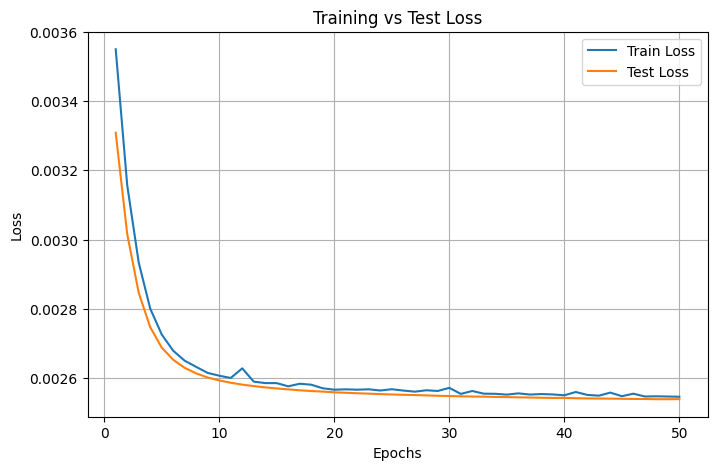

In [49]:
plot_loss(train_losses, test_losses)

Use trained Encoder part to get the features for train, test and evaluation Data

In [50]:
train_features, train_coord_dl = extract_features_ae(trained_model, dataloader_train, device)
test_features, test_coord_dl = extract_features_ae(trained_model, dataloader_test, device)
eval_features, eval_coord_dl = extract_features_ae(trained_model, dataloader_eval, device)

train_features = train_features.cpu()
test_features = test_features.cpu()
eval_features = eval_features.cpu()

combined_train_features = torch.cat((train_features, test_features), dim=0)
combined_train_coords = train_coord_dl + test_coord_dl

K-means on extracted features

In [51]:
kmeans = train_kmeans_patches(combined_train_features, n_clusters=2, random_state=32)

train_subpatch_predictions = kmeans.predict(combined_train_features.reshape(combined_train_features.size(0), -1).numpy().astype(np.float32))
eval_subpatch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

/home/k64835/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Convert Subpatch labels to Field labels

In [52]:
threshold = config.patch_to_field_threshold
train_field_labels = assign_field_labels_ae(combined_train_coords, train_subpatch_predictions, threshold)
eval_field_labels = assign_field_labels_ae(eval_coord_dl, eval_subpatch_predictions, threshold)

Clustering Accuracy

In [54]:
acc, precision_per_class, recall_per_class, f1_per_class, fmi = evaluate_clustering_metrics(eval_field_labels, config.labels_path)
print("Accuracy:",acc)
print("Precision:",precision_per_class)
print("Recall:",recall_per_class)
print("F1-score:",f1_per_class)
print("F2-score:", fmi)

Accuracy: 0.5737704918032787
Precision: 0.6046511627906976
Recall: 0.7428571428571429
F1-score: 0.6666666666666666
F2-score: 0.7103825136612022


In [21]:
# with open(config.ae_b10_path, 'wb') as file:
#     pickle.dump(trained_model, file)

In [22]:
# with open(config.kmeans_ae_b10_path, 'wb') as file:
#     pickle.dump(kmeans, file)

## Architecture 3: Variational Autoencoder

In [8]:
class Conv3DVAE(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv3DVAE, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels

        # --- Encoder (3D Convolutions) ---
        self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- 1D Convolution (Time Aggregation) ---
        self.conv1d = nn.Conv1d(256 * patch_size * patch_size, 256 * patch_size * patch_size, kernel_size=time_steps, stride=1, padding=0, groups=128 * patch_size * patch_size)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * patch_size * patch_size, 512)
        self.fc_mu = nn.Linear(512, latent_size)      # Mean
        self.fc_logvar = nn.Linear(512, latent_size)  # Log Variance

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * patch_size * patch_size)

        # --- 1D Deconvolution to Expand Time Back ---
        self.deconv1d = nn.ConvTranspose1d(256 * patch_size * patch_size, 256 * patch_size * patch_size, kernel_size=time_steps, stride=1, padding=0, groups=128 * patch_size * patch_size)

        # --- 3D Deconvolutions ---
        self.unflatten = nn.Unflatten(1, (256, patch_size, patch_size))
        self.deconv1 = nn.ConvTranspose3d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose3d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose3d(64, in_channels, kernel_size=3, stride=1, padding=1)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # --- Encoder ---
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Reshape for 1D Conv ---
        b, c, t, h, w = x.shape  
        x = x.view(b, c * h * w, t)
        x = self.conv1d(x)             

        # --- Flatten and Fully Connected ---
        x = self.flatten(x)  
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        log_var = self.fc_logvar(x)
        
        # --- Reparameterization Trick ---
        z = self.reparameterize(mu, log_var)

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x)) 

        # --- Expand Time Back ---
        x = x.view(b, 256 * patch_size * patch_size, 1)
        x = self.deconv1d(x)

        # --- Reshape for 3D Deconvolutions ---
        x = x.view(b, -1, self.time_steps, h, w)

        # --- 3D Deconvolutions ---
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x_reconstructed = self.deconv3(x)

        return mu, log_var, z, x_reconstructed

### Training

In [26]:
device = 'cuda'
epochs = 50
lr = 0.0001
optimizer = 'Adam'
latent_dim=32
channels = 10
time_steps = 7
patch_size = config.subpatch_size

model = Conv3DVAE(channels, time_steps, latent_dim, config.subpatch_size)
device = torch.device(device)  
model.to(device)

Conv3DVAE(
  (conv1): Conv3d(10, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv1d): Conv1d(6400, 6400, kernel_size=(7,), stride=(1,), groups=3200)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=6400, out_features=512, bias=True)
  (fc_mu): Linear(in_features=512, out_features=32, bias=True)
  (fc_logvar): Linear(in_features=512, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=6400, bias=True)
  (deconv1d): ConvTranspose1d(6400, 6400, kernel_size=(7,), stride=(1,), groups=3200)
  (unflatten): Unflatten(dim=1, unflattened_size=(256, 5, 5))
  (deconv1): ConvTranspose3d(256, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deconv2): ConvTranspose3d(128, 64, kerne

In [27]:
trained_model, train_recon_losses, train_kl_losses, test_recon_losses, test_kl_losses  = train_model_vae(model, dataloader_train, dataloader_test, epochs=epochs, optimizer=optimizer, lr=lr, device=device)

Epoch 1/50
  Train Recon Loss: 401.8316, Train KL Loss: 6.9947
  Test Recon Loss: 144.9218, Test KL Loss: 12.1576
Epoch 2/50
  Train Recon Loss: 107.5448, Train KL Loss: 14.0402
  Test Recon Loss: 98.2290, Test KL Loss: 13.2490
Epoch 3/50
  Train Recon Loss: 82.5290, Train KL Loss: 13.8672
  Test Recon Loss: 75.6008, Test KL Loss: 14.0060
Epoch 4/50
  Train Recon Loss: 59.6050, Train KL Loss: 15.0158
  Test Recon Loss: 56.7955, Test KL Loss: 15.7719
Epoch 5/50
  Train Recon Loss: 44.6131, Train KL Loss: 16.0476
  Test Recon Loss: 40.1669, Test KL Loss: 15.6835
Epoch 6/50
  Train Recon Loss: 39.2818, Train KL Loss: 15.7970
  Test Recon Loss: 41.2969, Test KL Loss: 15.3545
Epoch 7/50
  Train Recon Loss: 36.9307, Train KL Loss: 15.4821
  Test Recon Loss: 38.1646, Test KL Loss: 15.1161
Epoch 8/50
  Train Recon Loss: 34.5895, Train KL Loss: 15.4595
  Test Recon Loss: 57.5113, Test KL Loss: 15.5382
Epoch 9/50
  Train Recon Loss: 32.9866, Train KL Loss: 15.6171
  Test Recon Loss: 43.5262, Tes

### Evaluation

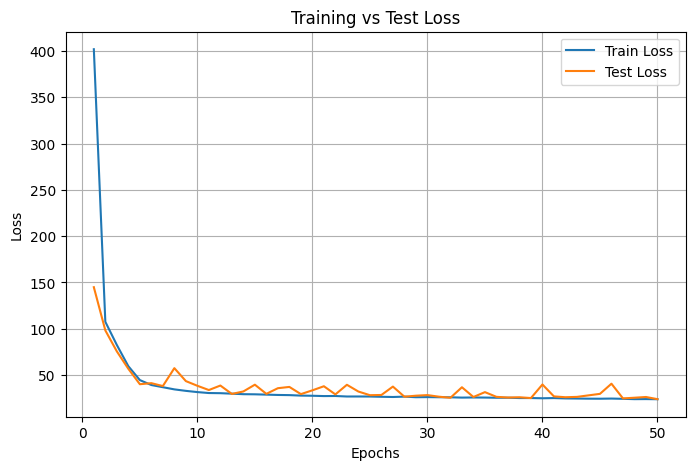

In [28]:
plot_loss(train_recon_losses, test_recon_losses)

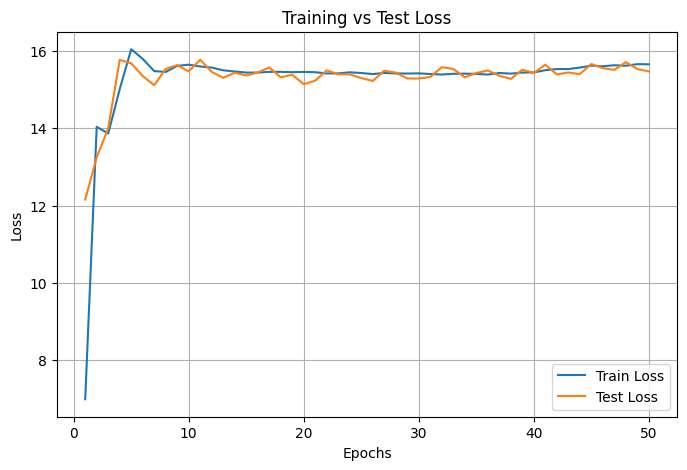

In [29]:
plot_loss(train_kl_losses, test_kl_losses)

Use trained Encoder part to get the features for train, test and evaluation Data

In [48]:
train_features, train_coord_dl = extract_features_vae(trained_model, dataloader_train, device)
test_features, test_coord_dl = extract_features_vae(trained_model, dataloader_test, device)
eval_features, eval_coord_dl = extract_features_vae(trained_model, dataloader_eval, device)

train_features = train_features.cpu()
test_features = test_features.cpu()
eval_features = eval_features.cpu()

combined_train_features = torch.cat((train_features, test_features), dim=0)
combined_train_coords = train_coord_dl + test_coord_dl

K-means on extracted features

In [49]:
kmeans = train_kmeans_patches(combined_train_features, n_clusters=2, random_state=27)

train_subpatch_predictions = kmeans.predict(combined_train_features.reshape(combined_train_features.size(0), -1).numpy().astype(np.float32))
eval_subpatch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

/home/k64835/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Convert Subpatch labels to Field labels

In [32]:
threshold = config.patch_to_field_threshold
train_field_labels = assign_field_labels_ae(combined_train_coords, train_subpatch_predictions, threshold)
eval_field_labels = assign_field_labels_ae(eval_coord_dl, eval_subpatch_predictions, threshold)

Accuracy and Classification Report

In [33]:
# accuracy, report, cm, x_y_coords = evaluate_test_labels_ae(eval_field_labels, config.labels_path)
# print(f"Evaluation Accuracy: {accuracy}")
# print(report)

Clustering Accuracy

In [34]:
acc, precision_per_class, recall_per_class, f1_per_class, fmi = evaluate_clustering_metrics(eval_field_labels, config.labels_path)
print("Accuracy:",acc)
print("Precision:",precision_per_class)
print("Recall:",recall_per_class)
print("F1-score:",f1_per_class)
print("Fowlkes-Mallows Index:",fmi)

Accuracy: 0.6557377049180327
Precision: [0.57142857 0.76923077]
Recall: [0.76923077 0.57142857]
F1-score: [0.6557377 0.6557377]
Fowlkes-Mallows Index: 0.5434782608695652


In [36]:
# with open(config.ae_b10_path, 'wb') as file:
#     pickle.dump(trained_model, file)

In [37]:
# with open(config.kmeans_ae_b10_path, 'wb') as file:
#     pickle.dump(kmeans, file)

## Architecture 4: Variational Autoencoder with time as channels

In [38]:
class Conv2DVAE(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv2DVAE, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels

        # --- Encoder (2D Convolutions, treating time steps as channels) ---
        self.conv1 = nn.Conv2d(in_channels * time_steps, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * patch_size * patch_size, 512)
        self.fc_mu = nn.Linear(512, latent_size)      # Mean
        self.fc_logvar = nn.Linear(512, latent_size)  # Log Variance

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * patch_size * patch_size)

        # --- 2D Deconvolutions ---
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, in_channels * time_steps, kernel_size=3, stride=1, padding=1)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):

        # --- Encoder ---
        b, c, t, h, w = x.shape
        x = x.view(b, c * t, h, w)      # Reshape to treat time steps as channels (B, C * D, H, W)
        # print(x.shape)

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Flatten and Fully Connected ---
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        log_var = self.fc_logvar(x)
        
        # --- Reparameterization Trick ---
        z = self.reparameterize(mu, log_var)

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))

        # --- 2D Deconvolutions ---
        x = x.view(b, 256, h, w)        # Reshape back to spatial dimensions
        # print(x.shape)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = self.deconv3(x)
        # print(x.shape)

        # --- Reshape to B x C x D x H x W ---
        x_reconstructed = x.view(b, self.in_channels, self.time_steps, h, w) 

        return mu, log_var, z, x_reconstructed

### Training

In [46]:
device = 'cuda'
epochs = 50
lr = 0.001
latent_dim=32
optimizer='Adam'
channels = 10
time_steps = 7
patch_size = config.subpatch_size

model = Conv2DVAE(channels, time_steps, latent_dim, config.subpatch_size)
device = torch.device(device)  
model.to(device)

Conv2DVAE(
  (conv1): Conv2d(70, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=6400, out_features=512, bias=True)
  (fc_mu): Linear(in_features=512, out_features=32, bias=True)
  (fc_logvar): Linear(in_features=512, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=6400, bias=True)
  (deconv1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv3): ConvTranspose2d(64, 70, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [47]:
trained_model, train_recon_losses, train_kl_losses, test_recon_losses, test_kl_losses  = train_model_vae(model, dataloader_train, dataloader_test, epochs=epochs, optimizer=optimizer, lr=lr, device=device)

Epoch 1/50
  Train Recon Loss: 474.2414, Train KL Loss: 2.3337
  Test Recon Loss: 213.7970, Test KL Loss: 6.1709
Epoch 2/50
  Train Recon Loss: 180.9515, Train KL Loss: 7.1876
  Test Recon Loss: 145.8411, Test KL Loss: 8.2506
Epoch 3/50
  Train Recon Loss: 133.6465, Train KL Loss: 6.8132
  Test Recon Loss: 135.4540, Test KL Loss: 6.0557
Epoch 4/50
  Train Recon Loss: 118.7133, Train KL Loss: 6.9423
  Test Recon Loss: 116.4041, Test KL Loss: 9.5347
Epoch 5/50
  Train Recon Loss: 95.0674, Train KL Loss: 8.2176
  Test Recon Loss: 99.7035, Test KL Loss: 7.6428
Epoch 6/50
  Train Recon Loss: 92.1130, Train KL Loss: 7.5151
  Test Recon Loss: 94.5956, Test KL Loss: 7.5925
Epoch 7/50
  Train Recon Loss: 89.5634, Train KL Loss: 7.4376
  Test Recon Loss: 102.4747, Test KL Loss: 7.4363
Epoch 8/50
  Train Recon Loss: 88.1452, Train KL Loss: 7.4395
  Test Recon Loss: 112.3135, Test KL Loss: 7.7123
Epoch 9/50
  Train Recon Loss: 86.9557, Train KL Loss: 7.4855
  Test Recon Loss: 94.3899, Test KL Loss

### Evaluation

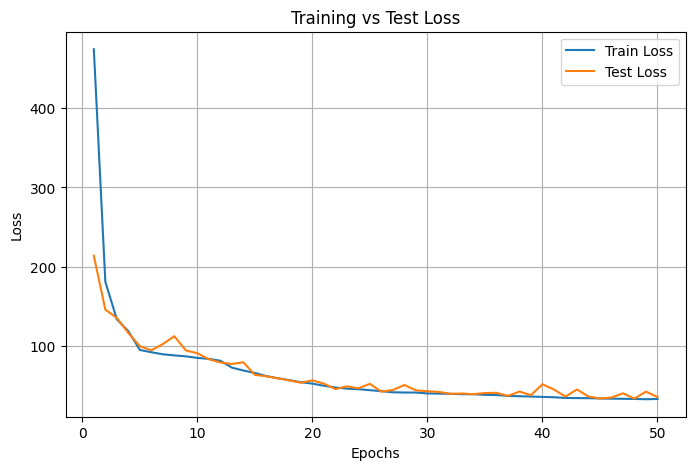

In [50]:
plot_loss(train_recon_losses, test_recon_losses)

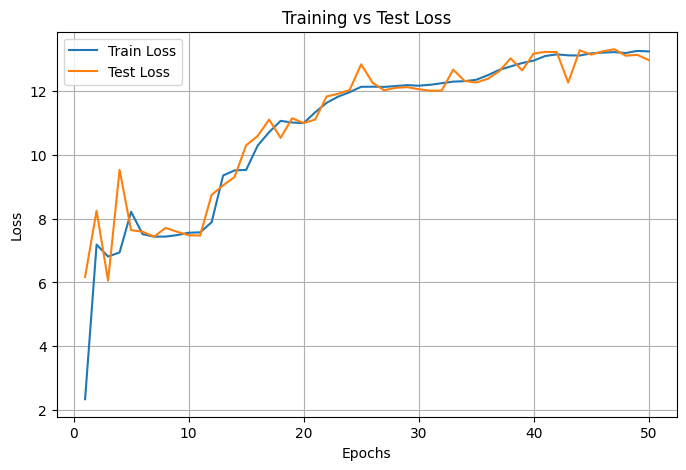

In [51]:
plot_loss(train_kl_losses, test_kl_losses)

Use trained Encoder part to get the features for train, test and evaluation Data

In [52]:
train_features, train_coord_dl = extract_features_vae(trained_model, dataloader_train, device)
test_features, test_coord_dl = extract_features_vae(trained_model, dataloader_test, device)
eval_features, eval_coord_dl = extract_features_vae(trained_model, dataloader_eval, device)

train_features = train_features.cpu()
test_features = test_features.cpu()
eval_features = eval_features.cpu()

combined_train_features = torch.cat((train_features, test_features), dim=0)
combined_train_coords = train_coord_dl + test_coord_dl

K-means on extracted features

In [53]:
kmeans = train_kmeans_patches(combined_train_features, n_clusters=2, random_state=26)

train_subpatch_predictions = kmeans.predict(combined_train_features.reshape(combined_train_features.size(0), -1).numpy().astype(np.float32))
eval_subpatch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

/home/k64835/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Convert Subpatch labels to Field labels

In [54]:
threshold = config.patch_to_field_threshold
train_field_labels = assign_field_labels_ae(combined_train_coords, train_subpatch_predictions, threshold)
eval_field_labels = assign_field_labels_ae(eval_coord_dl, eval_subpatch_predictions, threshold)

Accuracy and Classification Report

In [55]:
accuracy, report, cm, x_y_coords = evaluate_test_labels_ae(eval_field_labels, config.labels_path)
print(f"Evaluation Accuracy: {accuracy}")
print(report)

Evaluation Accuracy: 0.4426229508196721
              precision    recall  f1-score   support

           0       0.32      0.27      0.29        26
           1       0.51      0.57      0.54        35

    accuracy                           0.44        61
   macro avg       0.42      0.42      0.42        61
weighted avg       0.43      0.44      0.43        61



Clustering Accuracy

In [56]:
acc, precision_per_class, recall_per_class, f1_per_class, fmi = evaluate_clustering_metrics(eval_field_labels, config.labels_path)
print("Accuracy:",acc)
print("Precision:",precision_per_class)
print("Recall:",recall_per_class)
print("F1-score:",f1_per_class)
print("Fowlkes-Mallows Index:",fmi)

Accuracy: 0.5573770491803278
Precision: [0.48717949 0.68181818]
Recall: [0.73076923 0.42857143]
F1-score: [0.58461538 0.52631579]
Fowlkes-Mallows Index: 0.5149936985754042


In [57]:
with open(config.ae_b10_path, 'wb') as file:
    pickle.dump(trained_model, file)

In [58]:
with open(config.kmeans_ae_b10_path, 'wb') as file:
    pickle.dump(kmeans, file)

## Architecture 5: Conv2D Autoencoder with Residual Connections

### Architecture

In [ ]:
# class Conv2DAutoencoderRes(nn.Module):
#     def __init__(self, in_channels, time_steps, latent_size, patch_size):
#         super(Conv2DAutoencoderRes, self).__init__()

#         self.time_steps = time_steps
#         self.in_channels = in_channels

#         # --- Encoder (2D Convolutions with Residual Connections) ---
#         self.conv1 = nn.Conv2d(in_channels * time_steps, 64, kernel_size=3, stride=1, padding=1)
#         self.bn1 = nn.BatchNorm2d(64)  
#         self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
#         self.bn2 = nn.BatchNorm2d(128)  
#         self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
#         self.bn3 = nn.BatchNorm2d(256)  

#         # Skip connections
#         self.skip_conv1 = nn.Conv2d(in_channels * time_steps, 64, kernel_size=1, stride=1, padding=0)
#         self.skip_conv2 = nn.Conv2d(64, 128, kernel_size=1, stride=1, padding=0)
#         self.skip_conv3 = nn.Conv2d(128, 256, kernel_size=1, stride=1, padding=0)

#         # --- Fully Connected Latent Space ---
#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Linear(256 * patch_size * patch_size, 512)
#         self.fc2 = nn.Linear(512, latent_size)

#         # --- Decoder (Fully Connected) ---
#         self.fc3 = nn.Linear(latent_size, 512)
#         self.fc4 = nn.Linear(512, 256 * patch_size * patch_size)

#         # --- Decoder (2D Deconvolutions) ---
#         self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1)
#         self.bn4 = nn.BatchNorm2d(128)  
#         self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1)
#         self.bn5 = nn.BatchNorm2d(64)  
#         self.deconv3 = nn.ConvTranspose2d(64, in_channels * time_steps, kernel_size=3, stride=1, padding=1)

#         # Skip connections for decoder
#         self.skip_conv4 = nn.ConvTranspose2d(256, 128, kernel_size=1, stride=1, padding=0)
#         self.skip_conv5 = nn.ConvTranspose2d(128, 64, kernel_size=1, stride=1, padding=0)

#     def forward(self, x):
#         # --- Encoder ---
#         b, c, t, h, w = x.shape
#         x = x.view(b, c * t, h, w)          # Imp: Merge time steps into channels (B, C * D, H, W)

#         # Residual Block 1
#         skip_x = self.skip_conv1(x)  
#         x = F.relu(self.bn1(self.conv1(x)))  
#         x = x + skip_x  # Residual connection

#         # Residual Block 2
#         skip_x = self.skip_conv2(x)
#         x = F.relu(self.bn2(self.conv2(x)))  
#         x = x + skip_x  # Residual connection

#         # Residual Block 3
#         skip_x = self.skip_conv3(x)
#         x = F.relu(self.bn3(self.conv3(x)))  
#         x = x + skip_x  # Residual connection

#         # --- Flatten and Fully Connected ---
#         x = self.flatten(x)
#         x = F.relu(self.fc1(x))
#         z = self.fc2(x)

#         # --- Decoder ---
#         x = F.relu(self.fc3(z))
#         x = F.relu(self.fc4(x))

#         # --- 2D Deconvolutions ---
#         x = x.view(b, 256, h, w)

#         # Residual Block 4
#         skip_x = self.skip_conv4(x)  
#         x = F.relu(self.bn4(self.deconv1(x)))  
#         x = x + skip_x  # Residual connection

#         # Residual Block 5
#         skip_x = self.skip_conv5(x)  
#         x = F.relu(self.bn5(self.deconv2(x)))  
#         x = x + skip_x  # Residual connection

#         x = self.deconv3(x)

#         # --- Reshape to B x C x D x H x W ---
#         x_reconstructed = x.view(b, self.in_channels, self.time_steps, h, w)

#         return z, x_reconstructed


In [28]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, transpose=False):
        super(ResidualBlock, self).__init__()
        if transpose:
            self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding)
        else:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.skip_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0)

    def forward(self, x):
        skip_x = self.skip_conv(x)
        x = F.relu(self.bn(self.conv(x)))
        x = x + skip_x  # Residual connection
        return x


class Conv2DAutoencoderRes(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv2DAutoencoderRes, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels
        self.patch_size = patch_size

        # --- Encoder ---
        self.res_block1 = ResidualBlock(in_channels * time_steps, 64)
        self.res_block2 = ResidualBlock(64, 128)
        self.res_block3 = ResidualBlock(128, 256)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * patch_size * patch_size, 512)
        self.fc2 = nn.Linear(512, latent_size)

        # --- Decoder ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * patch_size * patch_size)

        # --- Decoder Residual Blocks with ConvTranspose2d (for upsampling) ---
        self.deconv_block1 = ResidualBlock(256, 128, transpose=True)
        self.deconv_block2 = ResidualBlock(128, 64, transpose=True)
        self.deconv_block3 = nn.ConvTranspose2d(64, in_channels * time_steps, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # Reshape input to (B, C * T, H, W)
        b, c, t, h, w = x.shape
        x = x.view(b, c * t, h, w)

        # --- Encoder ---
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)

        # --- Latent Space ---
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        z = self.fc2(x)

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))

        # Reshape for deconvolution
        x = x.view(b, 256, h, w)

        # Decoder with residual blocks (upsampling with ConvTranspose2d)
        x = self.deconv_block1(x)
        x = self.deconv_block2(x)
        x = self.deconv_block3(x)

        # Reshape output back to (B, C, T, H, W)
        x_reconstructed = x.view(b, self.in_channels, self.time_steps, h, w)

        return z, x_reconstructed


### Training

In [32]:
device = 'cuda'
epochs = 50
lr = 0.01
latent_dim=32
channels = 10
time_steps = 7
momentum=0.9
optimizer='SGD'
patch_size = config.subpatch_size

model = Conv2DAutoencoderRes(channels, time_steps, latent_dim, config.subpatch_size)
device = torch.device(device)  
model.to(device)

Conv2DAutoencoderRes(
  (res_block1): ResidualBlock(
    (conv): Conv2d(70, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (skip_conv): Conv2d(70, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (res_block2): ResidualBlock(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (skip_conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  )
  (res_block3): ResidualBlock(
    (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (skip_conv): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=6400, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=32, b

In [33]:
trained_model, train_losses, test_losses  = train_model_ae(model, dataloader_train, dataloader_test, epochs=epochs, optimizer=optimizer, lr=lr, momentum=momentum, device=device)

Epoch 1/50, Train Loss: 0.006793, Test Loss: 0.002076
Epoch 2/50, Train Loss: 0.001971, Test Loss: 0.001878
Epoch 3/50, Train Loss: 0.001808, Test Loss: 0.001734
Epoch 4/50, Train Loss: 0.001661, Test Loss: 0.001579
Epoch 5/50, Train Loss: 0.001520, Test Loss: 0.001460
Epoch 6/50, Train Loss: 0.001405, Test Loss: 0.001352
Epoch 7/50, Train Loss: 0.001300, Test Loss: 0.001260
Epoch 8/50, Train Loss: 0.001222, Test Loss: 0.001188
Epoch 9/50, Train Loss: 0.001155, Test Loss: 0.001130
Epoch 10/50, Train Loss: 0.001099, Test Loss: 0.001087
Epoch 11/50, Train Loss: 0.001058, Test Loss: 0.001030
Epoch 12/50, Train Loss: 0.001008, Test Loss: 0.000985
Epoch 13/50, Train Loss: 0.000973, Test Loss: 0.000954
Epoch 14/50, Train Loss: 0.000940, Test Loss: 0.000928
Epoch 15/50, Train Loss: 0.000911, Test Loss: 0.000896
Epoch 16/50, Train Loss: 0.000891, Test Loss: 0.000878
Epoch 17/50, Train Loss: 0.000863, Test Loss: 0.000842
Epoch 18/50, Train Loss: 0.000843, Test Loss: 0.000832
Epoch 19/50, Train 

### Evaluation

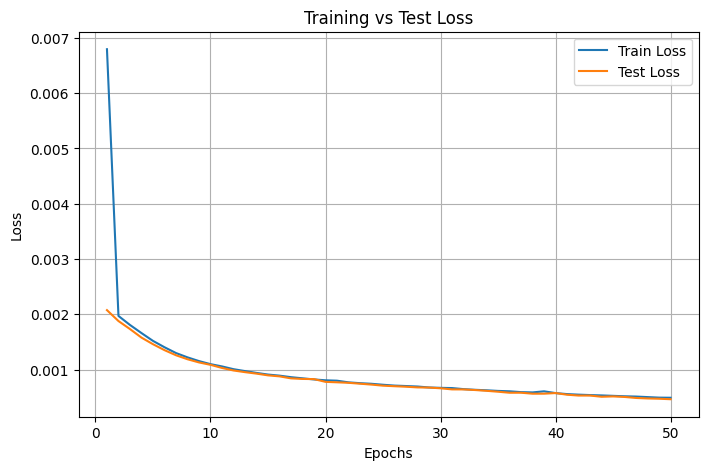

In [34]:
plot_loss(train_losses, test_losses)

Use trained Encoder part to get the features for train, test and evaluation Data

In [35]:
train_features, train_coord_dl = extract_features_ae(trained_model, dataloader_train, device)
test_features, test_coord_dl = extract_features_ae(trained_model, dataloader_test, device)
eval_features, eval_coord_dl = extract_features_ae(trained_model, dataloader_eval, device)

train_features = train_features.cpu()
test_features = test_features.cpu()
eval_features = eval_features.cpu()

combined_train_features = torch.cat((train_features, test_features), dim=0)
combined_train_coords = train_coord_dl + test_coord_dl

K-means on extracted features

In [37]:
kmeans = train_kmeans_patches(combined_train_features, n_clusters=2, random_state=33)

train_subpatch_predictions = kmeans.predict(combined_train_features.reshape(combined_train_features.size(0), -1).numpy().astype(np.float32))
eval_subpatch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

/home/k64835/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Convert Subpatch labels to Field labels

In [38]:
threshold = config.patch_to_field_threshold
train_field_labels = assign_field_labels_ae(combined_train_coords, train_subpatch_predictions, threshold)
eval_field_labels = assign_field_labels_ae(eval_coord_dl, eval_subpatch_predictions, threshold)

Accuracy and Classification Report

In [39]:
# accuracy, report, cm, x_y_coords = evaluate_test_labels_ae(eval_field_labels, config.labels_path)
# print(f"Evaluation Accuracy: {accuracy}")
# print(report)

Clustering Accuracy

In [42]:
acc, precision_per_class, recall_per_class, f1_per_class, fmi = evaluate_clustering_metrics(eval_field_labels, config.labels_path)
print("Accuracy:",acc)
print("Precision:",precision_per_class)
print("Recall:",recall_per_class)
print("F1-score:",f1_per_class)
print("F2-score:", fmi)

Accuracy: 0.5901639344262295
Precision: 0.625
Recall: 0.7142857142857143
F1-score: 0.6666666666666666
F2-score: 0.6944444444444444


In [ ]:
# with open(config.ae_b10_path, 'wb') as file:
#     pickle.dump(trained_model, file)

In [ ]:
# with open(config.kmeans_ae_b10_path, 'wb') as file:
#     pickle.dump(kmeans, file)

## Final Images: Visualising Diseased Subpatches

In [ ]:
eval_images_box = images_visualisation_eval

In [ ]:
(eval_images_box[0][0].shape)

(64, 64, 13)

In [ ]:
np.unique(eval_images_box[0][0][:,:,-2])

array([      0., 1168039.])

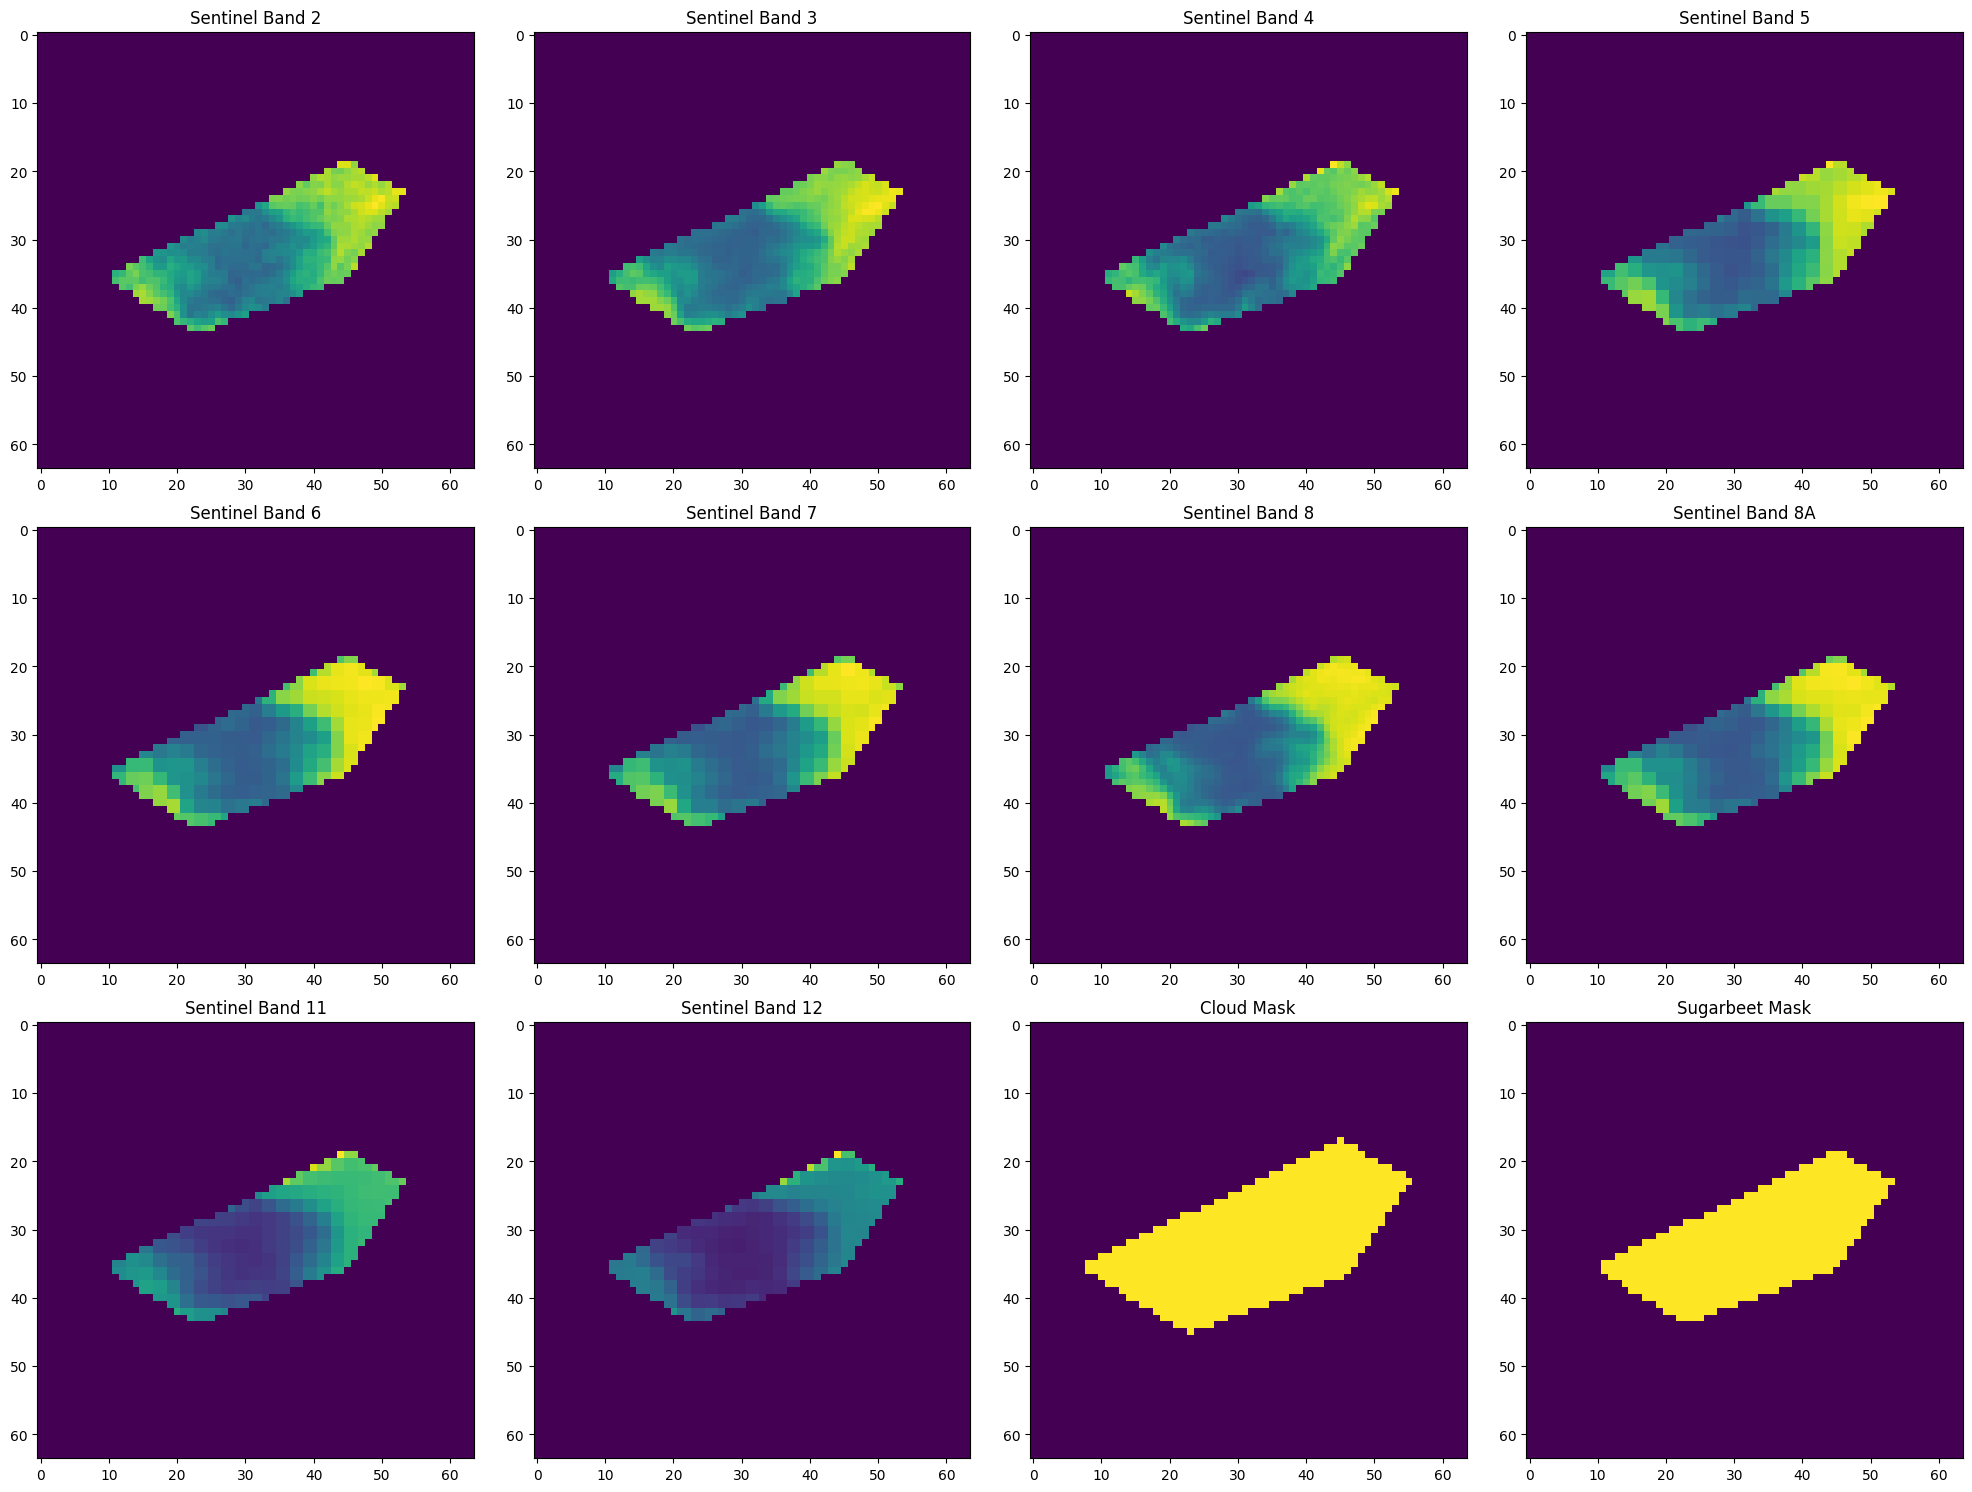

In [ ]:
visualise_all_bands(eval_images_box[-15][3])

-48 -26

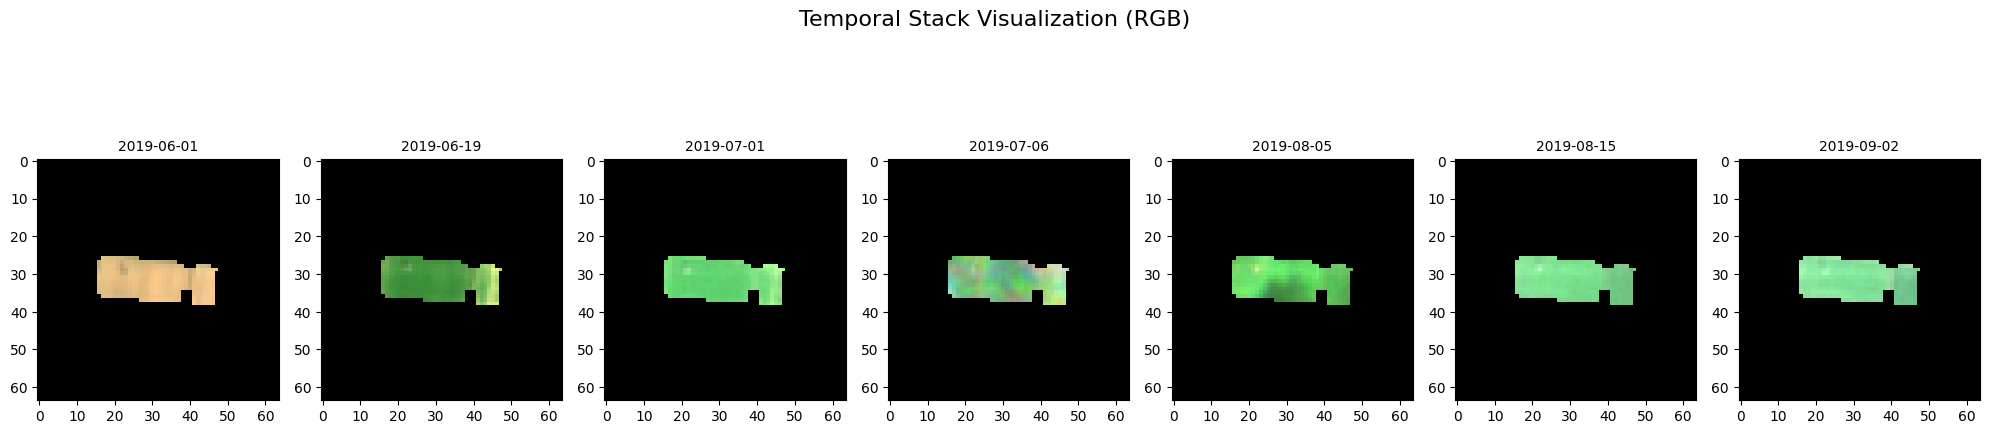

In [ ]:
visualize_temporal_stack_rgb(eval_images_box[-26])

In [ ]:
np.unique(eval_images_box[-26][-1][:,:,-2])

array([      0., 1196489., 1196747.])

Saved: /home/k64835/SITS-images/output/img_1168039.png
Saved: /home/k64835/SITS-images/output/img_1228889.png
Saved: /home/k64835/SITS-images/output/img_1168663.png
Saved: /home/k64835/SITS-images/output/img_1168692.png
Saved: /home/k64835/SITS-images/output/img_1171179.png
Saved: /home/k64835/SITS-images/output/img_1172001.png


/home/k64835/Master-Thesis-SITS/Modeling/model_scripts/superpixel.py:257: RuntimeWarning: invalid value encountered in divide
  


Saved: /home/k64835/SITS-images/output/img_1174805.png
Saved: /home/k64835/SITS-images/output/img_1176318.png
Saved: /home/k64835/SITS-images/output/img_1176365.png
Saved: /home/k64835/SITS-images/output/img_1177274.png
Saved: /home/k64835/SITS-images/output/img_1177490.png
Saved: /home/k64835/SITS-images/output/img_1177490.png
Saved: /home/k64835/SITS-images/output/img_1178038.png
Saved: /home/k64835/SITS-images/output/img_1178198.png
Saved: /home/k64835/SITS-images/output/img_1179855.png
Saved: /home/k64835/SITS-images/output/img_1182776.png
Saved: /home/k64835/SITS-images/output/img_1182822.png
Saved: /home/k64835/SITS-images/output/img_1183171.png
Saved: /home/k64835/SITS-images/output/img_1194806.png
Saved: /home/k64835/SITS-images/output/img_1196327.png
Saved: /home/k64835/SITS-images/output/img_1196347.png
Saved: /home/k64835/SITS-images/output/img_1196489.png
Saved: /home/k64835/SITS-images/output/img_1216230.png
Saved: /home/k64835/SITS-images/output/img_1216239.png
Saved: /ho

/home/k64835/.local/lib/python3.8/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


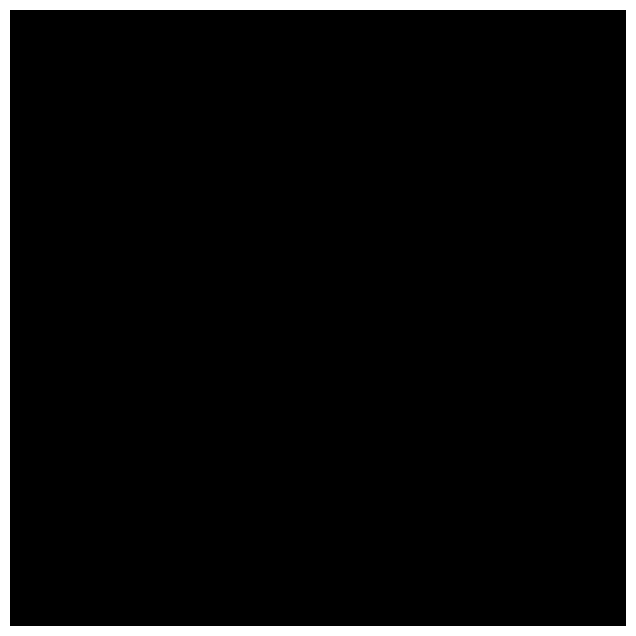

In [ ]:
draw_diseased_patches(eval_images_box, x_y_coords, config.images_save_path, config.patch_size)